### General results for all cell types. 


* general counts of credible sets


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re

import upsetplot as up
from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

# set higher figure resolution (for poster)
import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000


In [9]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/new_clusters/proteincoding_rewrite.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
clusters_dir = config['clusters_dir']
expression_dir = config['expression_dir']

# load in the tissue ids 
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])

### load in data

In [22]:
# load in the clusters data
clusters = {}
for tissue_id in tissue_df['Tissue']:
    clusters[tissue_id] = pd.read_csv(f'{prefix}/{clusters_dir}/{t}_clusters_all_chr.csv')
clusters_df = pd.concat(clusters, keys=tissue_df['Tissue'])


In [25]:
# load in expression data (so we only compare to pairs of genes also expressed in this tissue)
# load in expression data for all tissues 
expressions={}
for tissue_id in tissue_ids: 
    expressions[tissue_id] = pd.read_csv(f'{prefix}/{expression_dir}/{tissue_id}.v8.normalized_expression.bed', sep='\t')
    expressions[tissue_id] = expressions[tissue_id].sort_values(['#chr', 'start', 'end'])
    # we only need the transcript ids from the expression dir 
    expressions[tissue_id].drop(columns=expressions[tissue_id].columns[4:], inplace=True)
    
expression_df = pd.concat(expressions, keys=tissue_df['Tissue'])

In [49]:
tissue_pal = sns.color_palette('blend:#B83A4B,#FEC51D,#67AFD2', n_colors=len(tissue_ids))
tissue_pal

[(0.7215686274509804, 0.22745098039215686, 0.29411764705882354),
 (0.7667820069204152, 0.3172318339100346, 0.26440599769319495),
 (0.81199538638985, 0.40701268742791236, 0.23469434832756633),
 (0.859361783929258, 0.5010688196847367, 0.20356785851595538),
 (0.9045751633986928, 0.5908496732026144, 0.1738562091503268),
 (0.9497885428681276, 0.6806305267204922, 0.1441445597846982),
 (0.993756247597078, 0.7722106881968474, 0.11650903498654364),
 (0.8962245290272972, 0.758000768935025, 0.23341791618608226),
 (0.7986928104575164, 0.7437908496732026, 0.3503267973856209),
 (0.6965167243367936, 0.7289042675893888, 0.4728027681660899),
 (0.5989850057670127, 0.7146943483275663, 0.5897116493656285),
 (0.5014532871972318, 0.7004844290657439, 0.7066205305651673),
 (0.403921568627451, 0.6862745098039216, 0.8235294117647058)]

### What fraction of genes are in clusters?

In [46]:
frac_genes_in_clusters=[]
for tissue_id in tissue_ids: 
    all_cluster_transcripts = np.concatenate(clusters[tissue_id]['Transcripts'].str.split(',').values)
    frac_genes_in_clusters.append(sum(expressions[tissue_id]['gene_id'].isin(all_cluster_transcripts))/len(expressions[tissue_id]))

In [52]:
frac_df = pd.DataFrame({'tissue_id': tissue_ids, 'fraction':frac_genes_in_clusters})
frac_df['fraction'].mean()

0.11723122019976423

/local/scratch/klawren/slrmtmp.43144458/ipykernel_62323/3133701053.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(pd.DataFrame({'tissue_id': tissue_ids, 'fraction':frac_genes_in_clusters}), x='fraction', y='tissue_id', palette=tissue_pal, saturation=1, edgecolor='k', width=.85)


<AxesSubplot: xlabel='fraction', ylabel='tissue_id'>

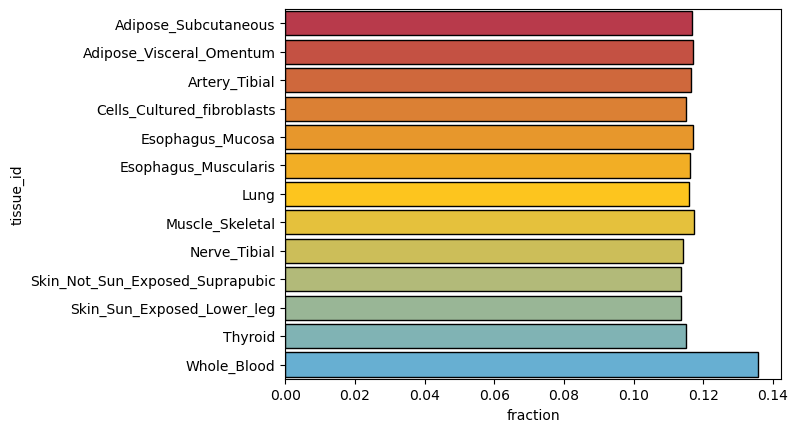

In [50]:
sns.barplot(pd.DataFrame({'tissue_id': tissue_ids, 'fraction':frac_genes_in_clusters}), x='fraction', y='tissue_id', palette=tissue_pal, saturation=1, edgecolor='k', width=.85)

## Clusters per tissue

In [5]:
# create a dataframe with the number of clusters for each tissue 
cs_counts_df = pd.DataFrame({'tissue':tissue_df['Tissue'], 
                       'num_clusters':[sum(clusters_df['Tissue'] == t) for t in tissue_df['Tissue']]})


/local/scratch/klawren/slrmtmp.43144458/ipykernel_62323/4080252346.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


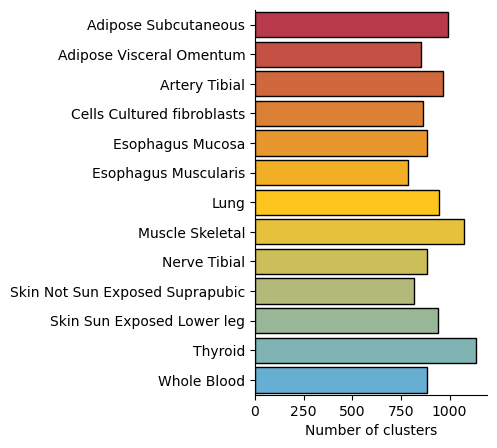

In [7]:
# plot showing number of clusters in each tissue

fig, ax = plt.subplots(figsize=(3,5))

ax = sns.barplot(cs_counts_df, x='num_clusters', hue='tissue', y='tissue', palette=tissue_pal, saturation=1, edgecolor='k', width=.85, ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

ax.set_xlabel('Number of clusters')
ax.set_ylabel('')

plt.show()


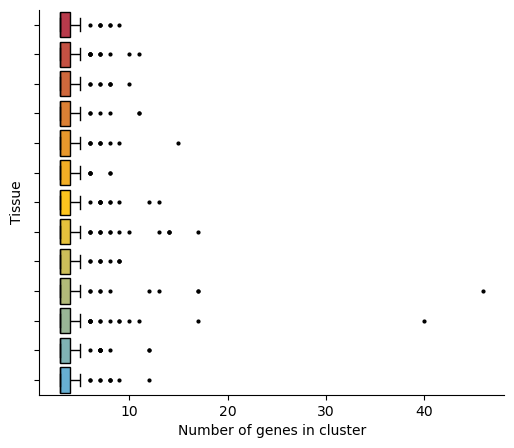

In [8]:
# plot showing distribution of clsuter sizes in each tissue
clusters_df['num_genes'] = clusters_df['Transcripts'].str.split(',').apply(len)


fig, ax = plt.subplots(figsize=(6,5))


PROPS = {
    'boxprops':{ 'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}, 
    'flierprops':{'markerfacecolor':'k', 'markersize':2,'linestyle':'none', 'markeredgecolor':'k',}}

sns.boxplot(clusters_df[clusters_df['num_genes']>2], x='num_genes', hue='Tissue', y='Tissue', ax=ax, palette=tissue_pal, saturation=1, width=.85, **PROPS)

# remove labels
ax.set_yticklabels('')

ax.set_xlabel('Number of genes in cluster')
#ax.set_ylabel('')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
